# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [52]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

### Load dataframes

In [72]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

In [73]:
df_train.tail()

,filename,FaceOcclusion,gender
101340,database3/database3/m.01drbr/85-FaceId-0_align...,0.017,1.000
101341,database3/database3/m.01drbr/86-FaceId-0_align...,0.152,1.000
101342,database3/database3/m.01drbr/87-FaceId-0_align...,0.004,0.999
101343,database3/database3/m.01drbr/90-FaceId-0_align...,0.012,1.000
101344,database3/database3/m.01drbr/92-FaceId-0_align...,0.036,1.000


In [74]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


#### Remove nan values

In [75]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Split Dataframe in train and val

In [8]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 假设 df_train 已经加载

# 随机打乱数据集
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# 将数据集分割为训练集和验证集，80% 用于训练，20% 用于验证
df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# 重置索引
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# 查看结果
print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender
0                          database1/img00015966.jpg          0.015   0.997
1  database3/database3/m.01bczm/134-FaceId-0_alig...          0.011   0.998
2  database3/database3/m.01bldq/0-FaceId-0_align.jpg          0.071   0.997
3                          database1/img00017957.jpg          0.351   0.001
4                          database1/img00020727.jpg          0.128   0.001

Validation set:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01b1jr/84-FaceId-0_align...          0.061   1.000
1  database3/database3/m.018j3w/68-FaceId-0_align...          0.213   0.845
2  database3/database3/m.01bjs2/47-FaceId-0_align...          0.195   0.999
3                          database1/img00010973.jpg          0.015   0.999
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001


In [77]:
len(df_train), len(df_val), len(df_test)

(81072, 20269, 30507)

<Axes: >

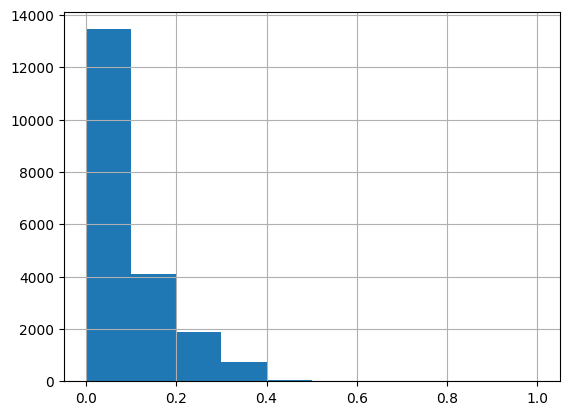

In [100]:
df_val['FaceOcclusion'].hist()

### Check that all images are read correctly

In [7]:
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        filename = df_train.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)
        
for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
    try:
        filename = df_test.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)

100%|██████████| 30507/30507 [03:08<00:00, 161.73it/s]


### Display first images

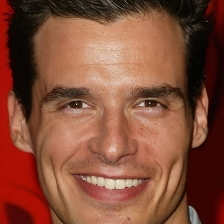

database1/img00015966.jpg 0.015 0.997


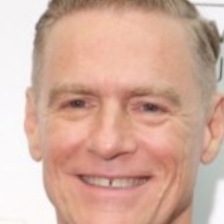

database3/database3/m.01bczm/134-FaceId-0_align.jpg 0.011 0.998


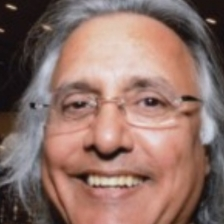

database3/database3/m.01bldq/0-FaceId-0_align.jpg 0.071 0.997


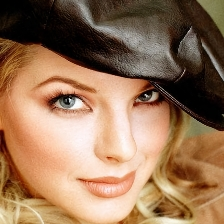

database1/img00017957.jpg 0.351 0.001


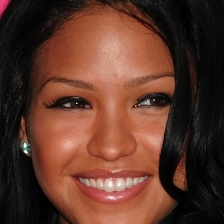

database1/img00020727.jpg 0.128 0.001


In [8]:
for idx, row in df_train[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

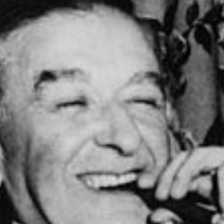

database3/database3/m.01b1jr/84-FaceId-0_align.jpg 0.061 1.0


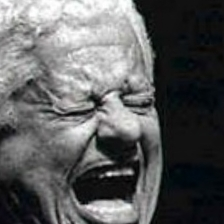

database3/database3/m.018j3w/68-FaceId-0_align.jpg 0.213 0.845


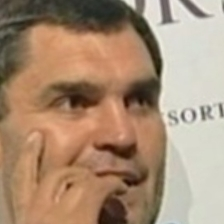

database3/database3/m.01bjs2/47-FaceId-0_align.jpg 0.195 0.999


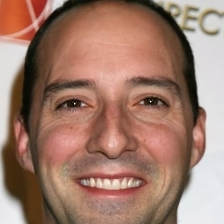

database1/img00010973.jpg 0.015 0.999


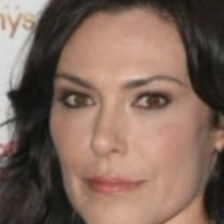

database3/database3/m.01541z/61-FaceId-0_align.jpg 0.108 0.001


In [9]:
for idx, row in df_val[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

### Make Dataset and Dataloader

In [78]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [79]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### Create naive model

In [12]:
'''
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    
model
'''

'\nmodel = torchvision.models.mobilenet_v3_small(num_classes=1)\nif torch.cuda.is_available():\n    model.cuda()    \nmodel\n'

### Loss and optimizer

In [15]:
loss_fn = nn.MSELoss()

### Train naive model

In [80]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#### Fit on train split

In [103]:
# 定义覆盖率范围
bins = [0, 0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 1.0]
labels = ['0-0.05', '0.05-0.1','0.1-0.15', '0.15-0.2','0.2-0.25', '0.25-0.3','0.3-0.35', '>0.35']

# 统计每个范围的样本数量
df_train['range'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train['range'].value_counts().sort_index()
print(range_counts)

# 计算权重
total_samples = len(df_train)
weights = {label: total_samples / count for label, count in range_counts.items()}
print(weights)


range
0-0.05      39242
0.05-0.1    14879
0.1-0.15    10066
0.15-0.2     6533
0.2-0.25     4285
0.25-0.3     3081
0.3-0.35     1869
>0.35        1117
Name: count, dtype: int64
{'0-0.05': 2.0659497477192805, '0.05-0.1': 5.448753276429867, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}


In [104]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()



In [131]:
# 加载预训练的ResNet模型并修改其最后一层
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 定义自定义损失函数
criterion = WeightedMSELoss(weights)

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        # 根据FaceOcclusion值计算range
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


  0%|          | 0/10134 [00:00<?, ?it/s]

Batch 0, Loss: 0.4881199598312378

  0%|          | 4/10134 [00:00<10:53, 15.49it/s]

 20%|█▉        | 2006/10134 [01:02<04:14, 32.00it/s]

Batch 2000, Loss: 0.010785256512463093


 40%|███▉      | 4006/10134 [02:04<03:10, 32.17it/s]

Batch 4000, Loss: 0.00884390901774168


 59%|█████▉    | 6006/10134 [03:06<02:07, 32.47it/s]

Batch 6000, Loss: 0.02271050587296486


 79%|███████▉  | 8006/10134 [04:08<01:05, 32.47it/s]

Batch 8000, Loss: 0.03005404770374298


 99%|█████████▊| 10006/10134 [05:10<00:03, 32.47it/s]

Batch 10000, Loss: 0.011621566489338875


100%|██████████| 10134/10134 [05:14<00:00, 32.25it/s]


Epoch [1/20], Loss: 0.03997844863881526
Epoch 2/20


  0%|          | 4/10134 [00:00<05:20, 31.62it/s]

Batch 0, Loss: 0.01369398832321167


 20%|█▉        | 2004/10134 [01:02<04:13, 32.03it/s]

Batch 2000, Loss: 0.009238054975867271


 40%|███▉      | 4004/10134 [02:04<03:09, 32.31it/s]

Batch 4000, Loss: 0.012281558476388454


 59%|█████▉    | 6004/10134 [03:05<02:07, 32.45it/s]

Batch 6000, Loss: 0.00872332789003849


 79%|███████▉  | 8004/10134 [04:07<01:05, 32.71it/s]

Batch 8000, Loss: 0.008620739914476871


 99%|█████████▊| 10004/10134 [05:09<00:04, 32.41it/s]

Batch 10000, Loss: 0.0014869477599859238


100%|██████████| 10134/10134 [05:13<00:00, 32.34it/s]


Epoch [2/20], Loss: 0.012207698685814753
Epoch 3/20


  0%|          | 4/10134 [00:00<05:21, 31.55it/s]

Batch 0, Loss: 0.0018923082388937473


 20%|█▉        | 2004/10134 [01:01<04:11, 32.27it/s]

Batch 2000, Loss: 0.009147388860583305


 40%|███▉      | 4004/10134 [02:03<03:06, 32.87it/s]

Batch 4000, Loss: 0.004577456973493099


 59%|█████▉    | 6004/10134 [03:04<02:09, 31.91it/s]

Batch 6000, Loss: 0.004890085197985172


 79%|███████▉  | 8003/10134 [04:06<01:05, 32.58it/s]

Batch 8000, Loss: 0.02632306143641472


 99%|█████████▊| 10003/10134 [05:08<00:04, 32.17it/s]

Batch 10000, Loss: 0.05709183216094971


100%|██████████| 10134/10134 [05:12<00:00, 32.44it/s]


Epoch [3/20], Loss: 0.009299999605320004
Epoch 4/20


  0%|          | 4/10134 [00:00<05:25, 31.09it/s]

Batch 0, Loss: 0.000718042952939868


 20%|█▉        | 2004/10134 [01:01<04:08, 32.75it/s]

Batch 2000, Loss: 0.0010974605102092028


 40%|███▉      | 4004/10134 [02:03<03:10, 32.24it/s]

Batch 4000, Loss: 0.0042997198179364204


 59%|█████▉    | 6004/10134 [03:05<02:08, 32.16it/s]

Batch 6000, Loss: 0.005733780097216368


 79%|███████▉  | 8004/10134 [04:06<01:05, 32.48it/s]

Batch 8000, Loss: 0.010675749741494656


 99%|█████████▊| 10004/10134 [05:08<00:03, 32.76it/s]

Batch 10000, Loss: 0.0025504371151328087


100%|██████████| 10134/10134 [05:12<00:00, 32.46it/s]


Epoch [4/20], Loss: 0.007304167554312196
Epoch 5/20


  0%|          | 4/10134 [00:00<05:23, 31.35it/s]

Batch 0, Loss: 0.017175938934087753


 20%|█▉        | 2003/10134 [01:01<04:33, 29.71it/s]

Batch 2000, Loss: 0.004470149986445904


 40%|███▉      | 4003/10134 [02:03<03:10, 32.21it/s]

Batch 4000, Loss: 0.008330204524099827


 59%|█████▉    | 6003/10134 [03:05<02:06, 32.60it/s]

Batch 6000, Loss: 0.0021245847456157207


 79%|███████▉  | 8003/10134 [04:06<01:05, 32.74it/s]

Batch 8000, Loss: 0.000945290841627866


 99%|█████████▊| 10003/10134 [05:08<00:04, 32.43it/s]

Batch 10000, Loss: 0.0039061238057911396


100%|██████████| 10134/10134 [05:12<00:00, 32.41it/s]


Epoch [5/20], Loss: 0.006271498405521
Epoch 6/20


  0%|          | 3/10134 [00:00<05:40, 29.79it/s]

Batch 0, Loss: 0.010189054533839226


 20%|█▉        | 2003/10134 [01:02<04:12, 32.24it/s]

Batch 2000, Loss: 0.0009094073320738971


 40%|███▉      | 4003/10134 [02:04<03:11, 32.03it/s]

Batch 4000, Loss: 0.004339983686804771


 59%|█████▉    | 6003/10134 [03:05<02:07, 32.45it/s]

Batch 6000, Loss: 0.0027203503996133804


 79%|███████▉  | 8003/10134 [04:07<01:07, 31.80it/s]

Batch 8000, Loss: 0.008463067933917046


 99%|█████████▊| 10003/10134 [05:09<00:04, 32.59it/s]

Batch 10000, Loss: 0.0003067425568588078


100%|██████████| 10134/10134 [05:13<00:00, 32.30it/s]


Epoch [6/20], Loss: 0.005373932697371088
Epoch 7/20


  0%|          | 4/10134 [00:00<05:30, 30.64it/s]

Batch 0, Loss: 0.002158564515411854


 20%|█▉        | 2004/10134 [01:01<04:08, 32.65it/s]

Batch 2000, Loss: 0.0008994745439849794


 40%|███▉      | 4004/10134 [02:03<03:07, 32.75it/s]

Batch 4000, Loss: 0.0020291816908866167


 59%|█████▉    | 6004/10134 [03:05<02:07, 32.44it/s]

Batch 6000, Loss: 0.003527485067024827


 79%|███████▉  | 8004/10134 [04:07<01:05, 32.56it/s]

Batch 8000, Loss: 0.004069212824106216


 99%|█████████▊| 10004/10134 [05:08<00:03, 32.53it/s]

Batch 10000, Loss: 0.0011101386044174433


100%|██████████| 10134/10134 [05:12<00:00, 32.41it/s]


Epoch [7/20], Loss: 0.004406109530221129
Epoch 8/20


  0%|          | 3/10134 [00:00<05:48, 29.03it/s]

Batch 0, Loss: 0.030239831656217575


 20%|█▉        | 2003/10134 [01:01<04:15, 31.88it/s]

Batch 2000, Loss: 0.006395265925675631


 40%|███▉      | 4007/10134 [02:04<03:07, 32.62it/s]

Batch 4000, Loss: 0.004652329254895449


 59%|█████▉    | 6003/10134 [03:05<02:06, 32.53it/s]

Batch 6000, Loss: 0.00373702310025692


 79%|███████▉  | 8007/10134 [04:07<01:04, 32.87it/s]

Batch 8000, Loss: 0.00025695734075270593


 99%|█████████▊| 10003/10134 [05:08<00:04, 32.01it/s]

Batch 10000, Loss: 0.003743567503988743


100%|██████████| 10134/10134 [05:12<00:00, 32.40it/s]


Epoch [8/20], Loss: 0.004020559962283193
Epoch 9/20


  0%|          | 3/10134 [00:00<05:41, 29.68it/s]

Batch 0, Loss: 0.0018315896159037948


 20%|█▉        | 2007/10134 [01:02<04:13, 32.05it/s]

Batch 2000, Loss: 0.011461413465440273


 40%|███▉      | 4003/10134 [02:04<03:09, 32.28it/s]

Batch 4000, Loss: 0.004735915455967188


 59%|█████▉    | 6007/10134 [03:05<02:05, 32.82it/s]

Batch 6000, Loss: 0.0019962023943662643


 79%|███████▉  | 8003/10134 [04:07<01:06, 32.01it/s]

Batch 8000, Loss: 0.0024456544779241085


 99%|█████████▊| 10003/10134 [05:09<00:04, 32.02it/s]

Batch 10000, Loss: 0.00021005250164307654


100%|██████████| 10134/10134 [05:13<00:00, 32.32it/s]


Epoch [9/20], Loss: 0.003667871356560219
Epoch 10/20


  0%|          | 3/10134 [00:00<05:47, 29.16it/s]

Batch 0, Loss: 0.012605516240000725


 20%|█▉        | 2003/10134 [01:01<04:09, 32.53it/s]

Batch 2000, Loss: 0.0024559078738093376


 40%|███▉      | 4007/10134 [02:03<03:08, 32.58it/s]

Batch 4000, Loss: 0.0009171429555863142


 59%|█████▉    | 6003/10134 [03:05<02:08, 32.12it/s]

Batch 6000, Loss: 0.002815134823322296


 79%|███████▉  | 8003/10134 [04:07<01:05, 32.47it/s]

Batch 8000, Loss: 0.0012244851095601916


 99%|█████████▊| 10003/10134 [05:08<00:04, 32.54it/s]

Batch 10000, Loss: 0.002542948815971613


100%|██████████| 10134/10134 [05:12<00:00, 32.39it/s]


Epoch [10/20], Loss: 0.003288377502971832
Epoch 11/20


  0%|          | 4/10134 [00:00<05:25, 31.11it/s]

Batch 0, Loss: 0.005234334617853165


 20%|█▉        | 2004/10134 [01:01<04:11, 32.29it/s]

Batch 2000, Loss: 0.0015655939932912588


 40%|███▉      | 4004/10134 [02:03<03:12, 31.88it/s]

Batch 4000, Loss: 0.0020694881677627563


 59%|█████▉    | 6004/10134 [03:05<02:07, 32.49it/s]

Batch 6000, Loss: 0.001304719946347177


 79%|███████▉  | 8004/10134 [04:07<01:05, 32.60it/s]

Batch 8000, Loss: 0.001397973275743425


 99%|█████████▊| 10004/10134 [05:08<00:04, 30.91it/s]

Batch 10000, Loss: 0.011892891488969326


100%|██████████| 10134/10134 [05:12<00:00, 32.41it/s]


Epoch [11/20], Loss: 0.0028526385424551006
Epoch 12/20


  0%|          | 4/10134 [00:00<05:31, 30.60it/s]

Batch 0, Loss: 0.007851188071072102


 20%|█▉        | 2004/10134 [01:02<04:12, 32.20it/s]

Batch 2000, Loss: 0.0010569100268185139


 40%|███▉      | 4003/10134 [02:04<03:08, 32.55it/s]

Batch 4000, Loss: 0.0019817561842501163


 59%|█████▉    | 6007/10134 [03:05<02:06, 32.75it/s]

Batch 6000, Loss: 0.0017901061801239848


 79%|███████▉  | 8007/10134 [04:07<01:06, 32.22it/s]

Batch 8000, Loss: 0.001268482767045498


 99%|█████████▊| 10003/10134 [05:09<00:04, 32.31it/s]

Batch 10000, Loss: 0.0002964064769912511


100%|██████████| 10134/10134 [05:13<00:00, 32.29it/s]


Epoch [12/20], Loss: 0.0026030972339763626
Epoch 13/20


  0%|          | 4/10134 [00:00<05:28, 30.79it/s]

Batch 0, Loss: 0.03321992978453636


 20%|█▉        | 2004/10134 [01:02<04:13, 32.12it/s]

Batch 2000, Loss: 0.001433800207450986


 40%|███▉      | 4004/10134 [02:03<03:07, 32.65it/s]

Batch 4000, Loss: 0.0006376211531460285


 59%|█████▉    | 6004/10134 [03:05<02:09, 31.92it/s]

Batch 6000, Loss: 0.0024313756730407476


 79%|███████▉  | 8004/10134 [04:08<01:06, 32.22it/s]

Batch 8000, Loss: 0.0007698960835114121


 99%|█████████▊| 10004/10134 [05:10<00:04, 32.20it/s]

Batch 10000, Loss: 0.0054432060569524765


100%|██████████| 10134/10134 [05:14<00:00, 32.22it/s]


Epoch [13/20], Loss: 0.002436029017112146
Epoch 14/20


  0%|          | 4/10134 [00:00<05:32, 30.51it/s]

Batch 0, Loss: 0.0005372239975258708


 20%|█▉        | 2004/10134 [01:01<04:08, 32.68it/s]

Batch 2000, Loss: 0.0016548566054552794


 40%|███▉      | 4004/10134 [02:03<03:11, 32.08it/s]

Batch 4000, Loss: 0.004892625845968723


 59%|█████▉    | 6004/10134 [03:05<02:13, 30.88it/s]

Batch 6000, Loss: 0.0047146715223789215


 79%|███████▉  | 8004/10134 [04:07<01:05, 32.53it/s]

Batch 8000, Loss: 0.0018201407510787249


 99%|█████████▊| 10004/10134 [05:09<00:04, 32.35it/s]

Batch 10000, Loss: 0.00047490280121564865


100%|██████████| 10134/10134 [05:13<00:00, 32.35it/s]


Epoch [14/20], Loss: 0.0022582408041557462
Epoch 15/20


  0%|          | 4/10134 [00:00<05:21, 31.48it/s]

Batch 0, Loss: 0.0012844132725149393


 20%|█▉        | 2003/10134 [01:02<04:17, 31.63it/s]

Batch 2000, Loss: 0.00027189520187675953


 40%|███▉      | 4003/10134 [02:04<03:08, 32.55it/s]

Batch 4000, Loss: 0.004208248574286699


 59%|█████▉    | 6003/10134 [03:06<02:07, 32.33it/s]

Batch 6000, Loss: 0.0011772031430155039


 79%|███████▉  | 8007/10134 [04:07<01:05, 32.70it/s]

Batch 8000, Loss: 0.00471709156408906


 99%|█████████▊| 10003/10134 [05:09<00:04, 32.41it/s]

Batch 10000, Loss: 0.0016067367978394032


100%|██████████| 10134/10134 [05:13<00:00, 32.28it/s]


Epoch [15/20], Loss: 0.001993586283629286
Epoch 16/20


  0%|          | 3/10134 [00:00<05:53, 28.69it/s]

Batch 0, Loss: 0.0002629075606819242


 20%|█▉        | 2003/10134 [01:02<04:15, 31.87it/s]

Batch 2000, Loss: 0.00029788463143631816


 40%|███▉      | 4007/10134 [02:04<03:07, 32.62it/s]

Batch 4000, Loss: 0.0009148408425971866


 59%|█████▉    | 6003/10134 [03:05<02:07, 32.47it/s]

Batch 6000, Loss: 0.0026239673607051373


 79%|███████▉  | 8003/10134 [04:07<01:07, 31.77it/s]

Batch 8000, Loss: 0.0006556238513439894


 99%|█████████▊| 10003/10134 [05:10<00:04, 32.19it/s]

Batch 10000, Loss: 0.001037995214574039


100%|██████████| 10134/10134 [05:14<00:00, 32.27it/s]


Epoch [16/20], Loss: 0.0018815367991988556
Epoch 17/20


  0%|          | 3/10134 [00:00<05:50, 28.87it/s]

Batch 0, Loss: 0.0025926921516656876


 20%|█▉        | 2006/10134 [01:01<04:08, 32.76it/s]

Batch 2000, Loss: 0.023448282852768898


 40%|███▉      | 4006/10134 [02:03<03:13, 31.69it/s]

Batch 4000, Loss: 0.0019482655916363


 59%|█████▉    | 6006/10134 [03:06<02:08, 32.01it/s]

Batch 6000, Loss: 0.0021080458536744118


 79%|███████▉  | 8006/10134 [04:08<01:05, 32.60it/s]

Batch 8000, Loss: 0.003623037599027157


 99%|█████████▊| 10006/10134 [05:09<00:03, 32.64it/s]

Batch 10000, Loss: 0.0013008846435695887


100%|██████████| 10134/10134 [05:13<00:00, 32.29it/s]


Epoch [17/20], Loss: 0.0017572373391124005
Epoch 18/20


  0%|          | 3/10134 [00:00<05:44, 29.37it/s]

Batch 0, Loss: 0.0002684046048671007


 20%|█▉        | 2003/10134 [01:02<04:14, 32.01it/s]

Batch 2000, Loss: 0.0006177965551614761


 40%|███▉      | 4003/10134 [02:04<03:10, 32.17it/s]

Batch 4000, Loss: 0.0007065419340506196


 59%|█████▉    | 6003/10134 [03:06<02:08, 32.25it/s]

Batch 6000, Loss: 0.0006430542562156916


 79%|███████▉  | 8007/10134 [04:08<01:05, 32.24it/s]

Batch 8000, Loss: 0.0010346976341679692


 99%|█████████▊| 10003/10134 [05:10<00:04, 32.18it/s]

Batch 10000, Loss: 0.0013779285363852978


100%|██████████| 10134/10134 [05:14<00:00, 32.20it/s]


Epoch [18/20], Loss: 0.001616831013917952
Epoch 19/20


  0%|          | 4/10134 [00:00<05:26, 31.05it/s]

Batch 0, Loss: 0.0006027949275448918


 20%|█▉        | 2004/10134 [01:02<04:11, 32.38it/s]

Batch 2000, Loss: 0.0006863275775685906


 40%|███▉      | 4004/10134 [02:04<03:08, 32.50it/s]

Batch 4000, Loss: 0.0011275052092969418


 59%|█████▉    | 6004/10134 [03:05<02:06, 32.66it/s]

Batch 6000, Loss: 0.0012953534023836255


 79%|███████▉  | 8004/10134 [04:08<01:06, 31.93it/s]

Batch 8000, Loss: 0.00022310417261905968


 99%|█████████▊| 10004/10134 [05:10<00:03, 32.53it/s]

Batch 10000, Loss: 0.0014859368093311787


100%|██████████| 10134/10134 [05:14<00:00, 32.21it/s]


Epoch [19/20], Loss: 0.0015795400091497798
Epoch 20/20


  0%|          | 3/10134 [00:00<07:39, 22.07it/s]

Batch 0, Loss: 0.0006102118641138077


 20%|█▉        | 2005/10134 [01:02<04:10, 32.51it/s]

Batch 2000, Loss: 0.0012595993466675282


 40%|███▉      | 4005/10134 [02:03<03:07, 32.68it/s]

Batch 4000, Loss: 0.001972292084246874


 59%|█████▉    | 6005/10134 [03:06<02:07, 32.38it/s]

Batch 6000, Loss: 0.0005487971939146519


 79%|███████▉  | 8005/10134 [04:08<01:05, 32.37it/s]

Batch 8000, Loss: 0.0018528902437537909


 99%|█████████▊| 10005/10134 [05:10<00:03, 32.34it/s]

Batch 10000, Loss: 0.0003233054303564131


100%|██████████| 10134/10134 [05:14<00:00, 32.26it/s]

Epoch [20/20], Loss: 0.0014308192896913994
Training complete


In [84]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet and modify it
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Define loss and optimizer
criterion = WeightedMSELoss(weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


'''


# 加载预训练的EfficientNet
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# 修改最后的全连接层
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''

Epoch 1/3


  0%|          | 0/10134 [00:00<?, ?it/s]


TypeError: WeightedMSELoss.forward() missing 1 required positional argument: 'ranges'

In [18]:
'''
num_epochs = 5

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

Epoch 0


  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]


NameError: name 'model' is not defined

## Face mesh

In [48]:
import cv2
import mediapipe as mp
import time
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

def get_face_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            return landmarks
    return None





In [50]:
class FaceOcclusionDataset(Dataset):
    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.df = df
        self.transform = transforms.ToTensor()
         
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        filename = row['filename']
        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        y = row['FaceOcclusion']
        gender = row['gender']
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        y = torch.tensor([y], dtype=torch.float32)
        return X, y, gender, filename

# 加载数据
training_set = FaceOcclusionDataset(df_train, image_dir)
validation_set = FaceOcclusionDataset(df_val, image_dir)

params_train = {'batch_size': 8, 'shuffle': True, 'num_workers': 0}
params_val = {'batch_size': 8, 'shuffle': False, 'num_workers': 0}

training_generator = DataLoader(training_set, **params_train)
validation_generator = DataLoader(validation_set, **params_val)


In [55]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(468*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


  0%|          | 0/8134 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


Epoch 1/3


  0%|          | 0/8134 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 1404]

## Evaluate metric on validation split

In [132]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [118]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

100%|██████████| 2534/2534 [01:21<00:00, 31.14it/s]


In [119]:
results_df.head()

,pred,target,gender
0,0.127986,0.061,1.000
1,0.240295,0.213,0.845
2,0.125518,0.195,0.999
3,0.028929,0.015,0.999
4,0.116574,0.108,0.001


<Axes: >

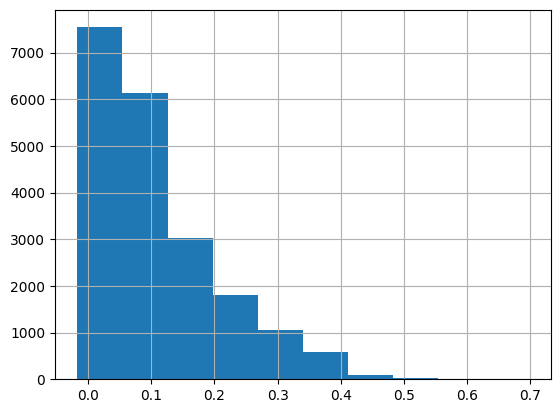

In [120]:
results_df['pred'].hist()

100%|██████████| 2534/2534 [01:11<00:00, 35.32it/s]


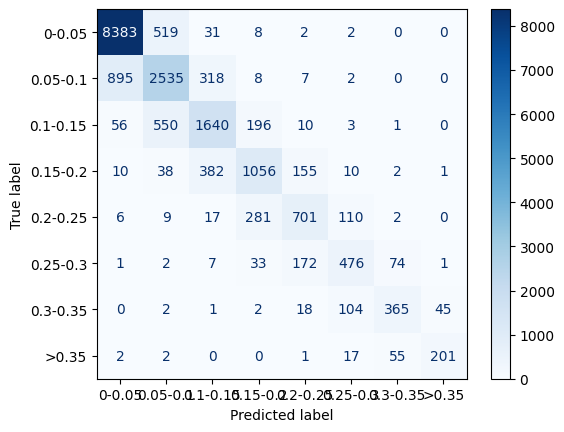

In [141]:
bins = [0, 0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 1.0]
labels = ['0-0.05', '0.05-0.1','0.1-0.15', '0.15-0.2','0.2-0.25', '0.25-0.3','0.3-0.35', '>0.35']

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [142]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)


In [143]:
metric_fn(results_male, results_female)

0.0011486337753639619
0.0009582482633185118


0.001243826531386687

## Evaluating your Test DataSet

In [135]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [ ]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

NameError: name 'face_mesh_detector' is not defined

In [136]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [137]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [01:44<00:00, 36.62it/s]


In [138]:
test_df.head()

,pred
0,0.291290
1,0.406681
2,0.468659
3,0.303948
4,0.409020


### Preparing your file for Submission

In [139]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 